#  Прогнозирование заказов такси

В нашем рапоряжении данные компании «Чётенькое такси» о заказах такси в аэропортах. 
 
Цель: Привлекать больше водителей в период пиковой нагрузки.

Задачи:
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы (Значение метрики *RMSE* на тестовой выборке должно быть не больше 48).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression#линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Lubov/jupyter/ds/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])#переводим в формат даты

In [6]:
df.info()#проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
df = df.set_index('datetime')#делаю столбец datetime индексом

In [8]:
df.sort_index(inplace=True)#сортирую индексы
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
print(df.index.is_monotonic_increasing)#проверка  в хронологичном ли порядке расположены даты

True


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные с 1 марта 2018 по 31 август 2018 г

In [11]:
df = df.resample('1H').sum()#ресемплирование по 1 часу
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [12]:
df.isna().sum()

num_orders    0
dtype: int64

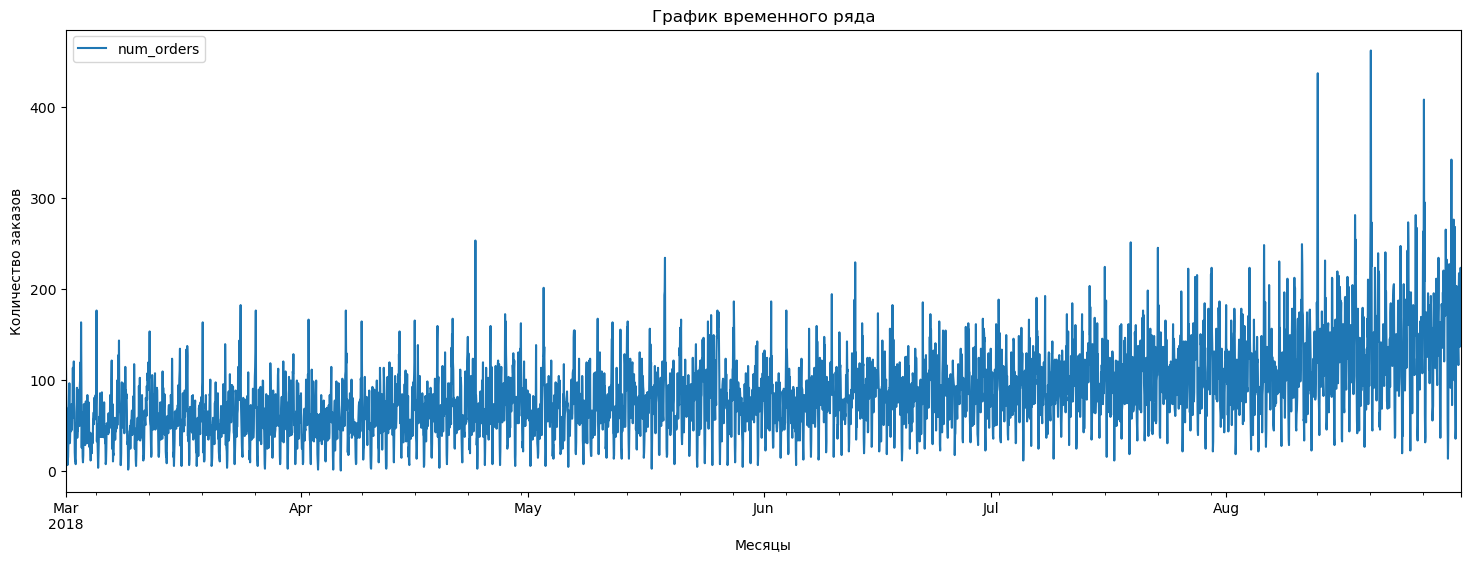

In [13]:
df.plot(figsize=(18, 6))
plt.title('График временного ряда')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.show()

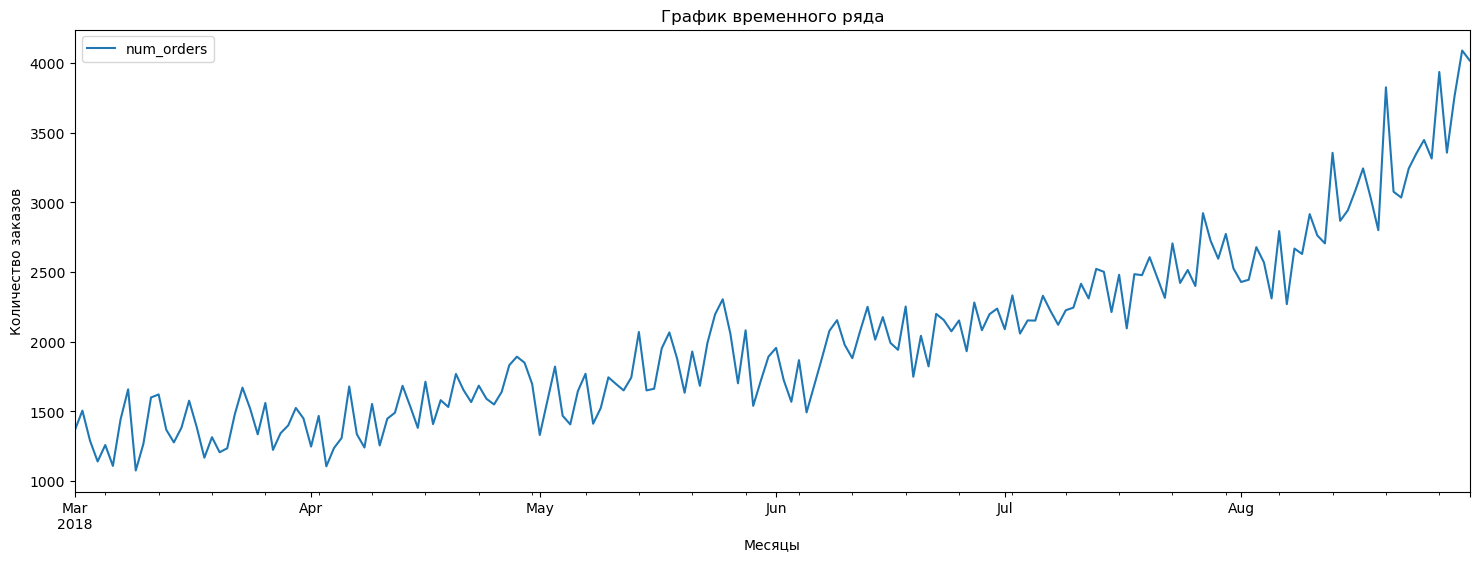

In [14]:
df1 = df.resample('1D').sum()#я решила посмотреть динамику при ресемплировании 1 день.
df1.plot(figsize=(18, 6))
plt.title('График временного ряда')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.show()

Если посмотреть суммарное число заказов за день, то видна динамика, количество заказов увеличивается. Данные имеют большие колебания, но мы уже видим восхдящий тренд.

### Вывод:

Я рассмотрела данные, в датасете 4416 строк, пропуски отсутствуют. Представлены данные с 1 марта 2018 по 31 август 2018 г. Выполнила ресемплирование по 1 часу, данные имеют большую частоту.

## Анализ

Проведем анализ, рассмотрим тренд, сезонность и остатки.
Изначально я рассмотрела данные по 1 часу, но слишком большая частотность приводит к нечитаемости. Рассмотрю по дням.

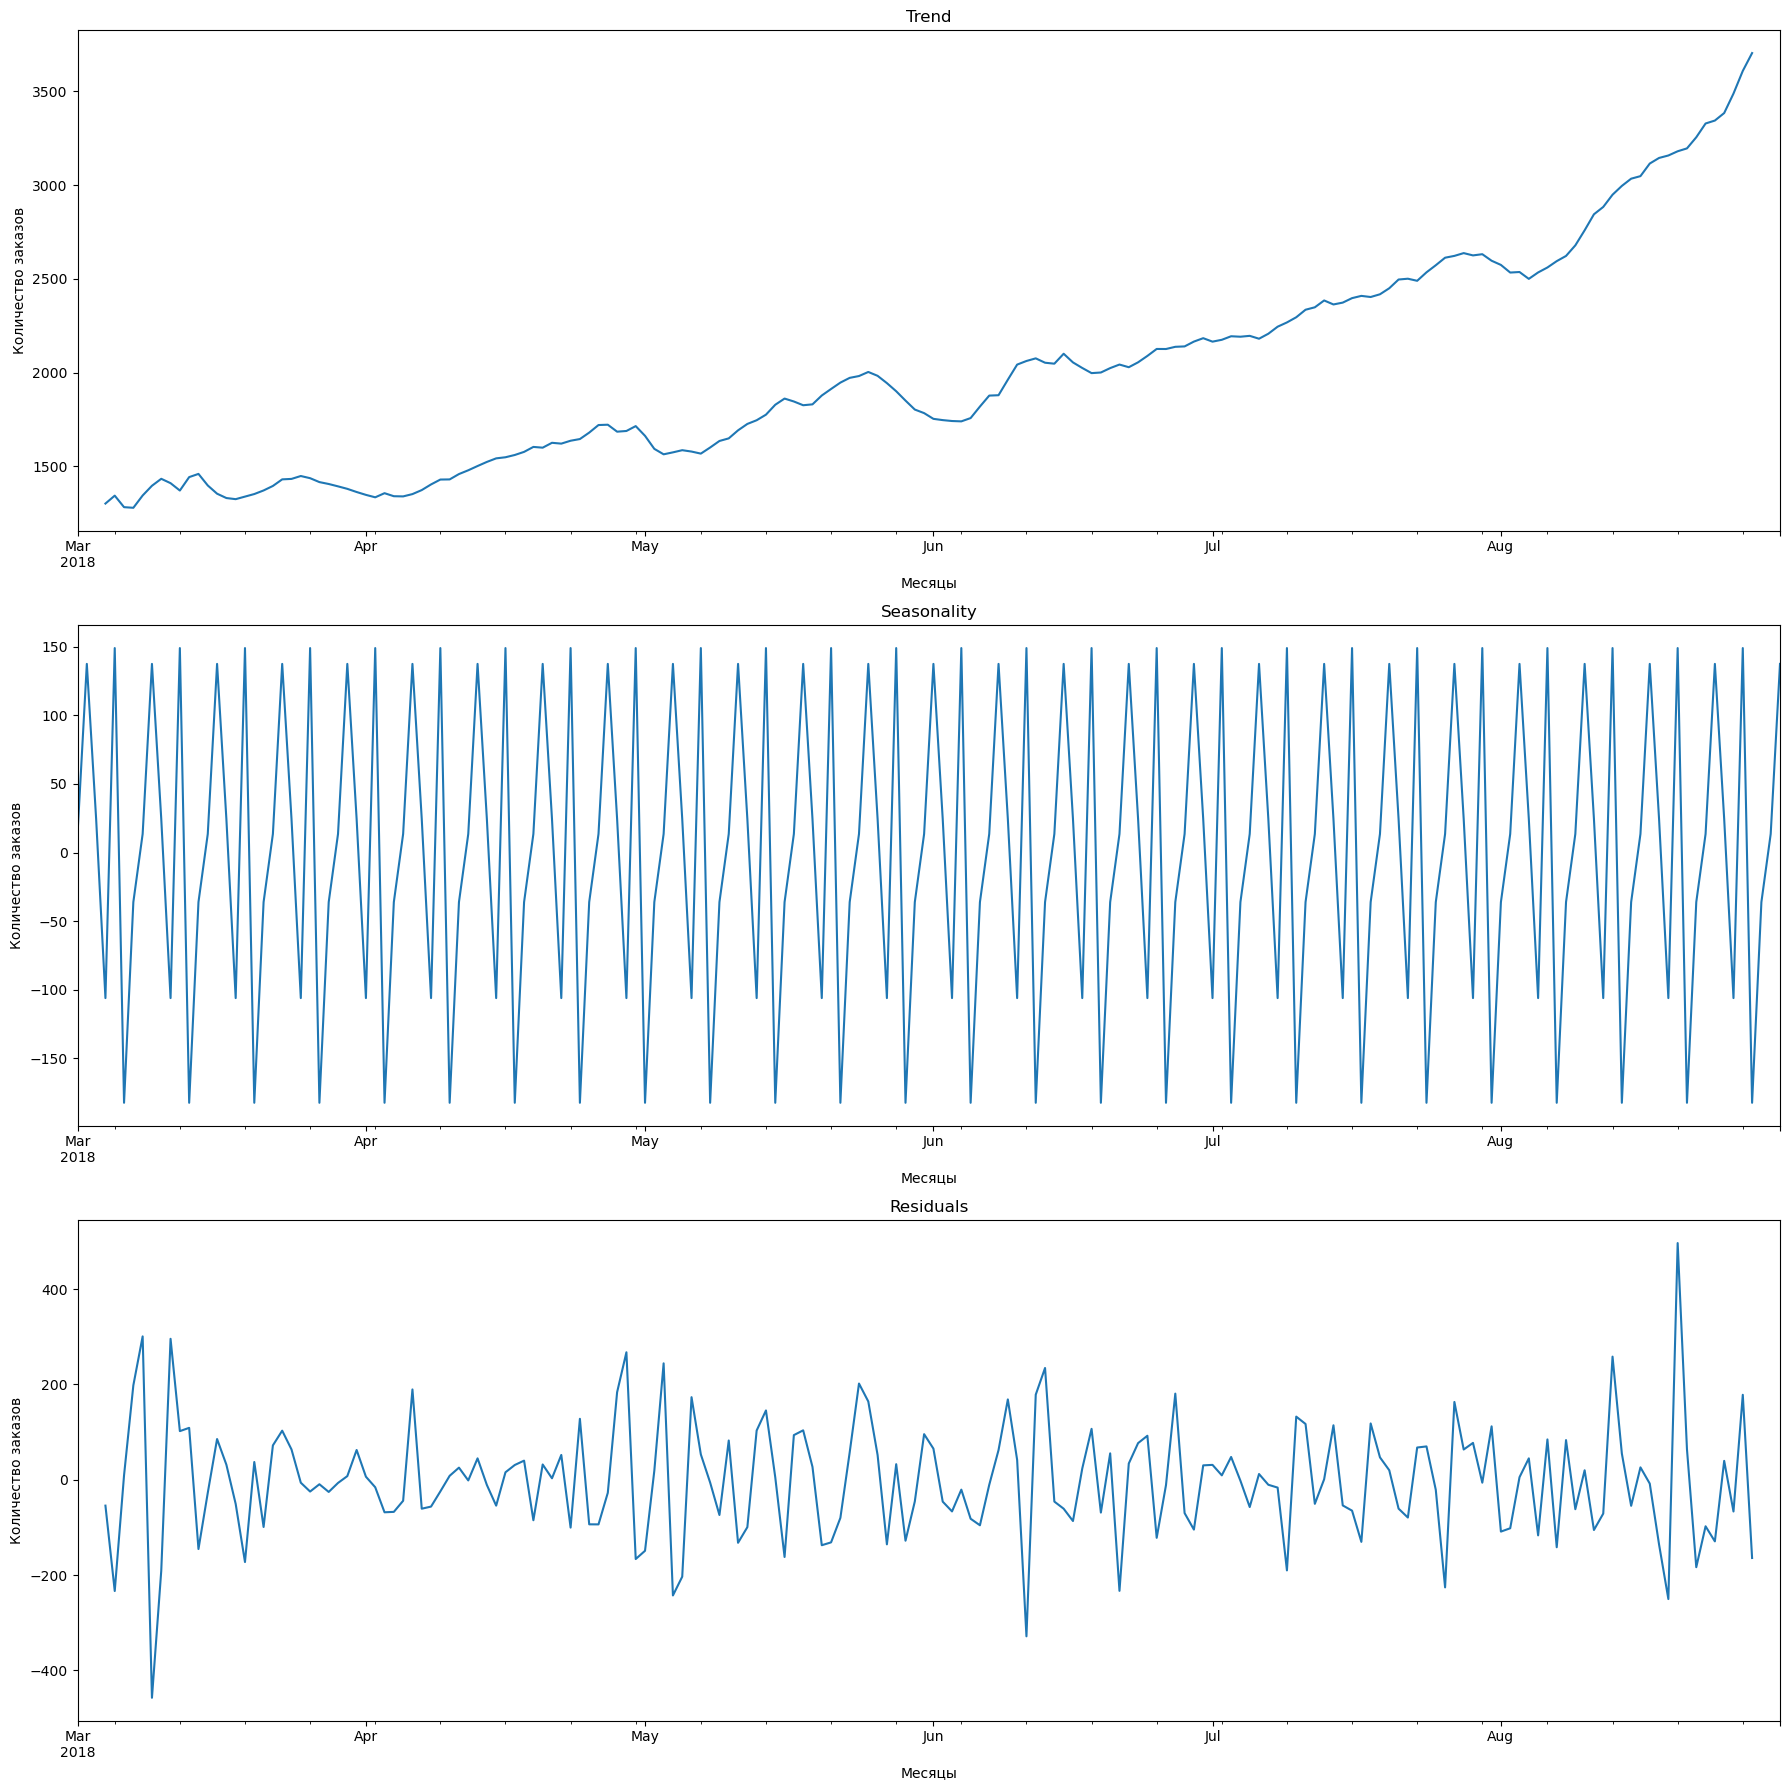

In [15]:
decomposed = seasonal_decompose(df1)

plt.figure(figsize=(18, 18))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.tight_layout()


plt.show()

Рассмотрю отрезок

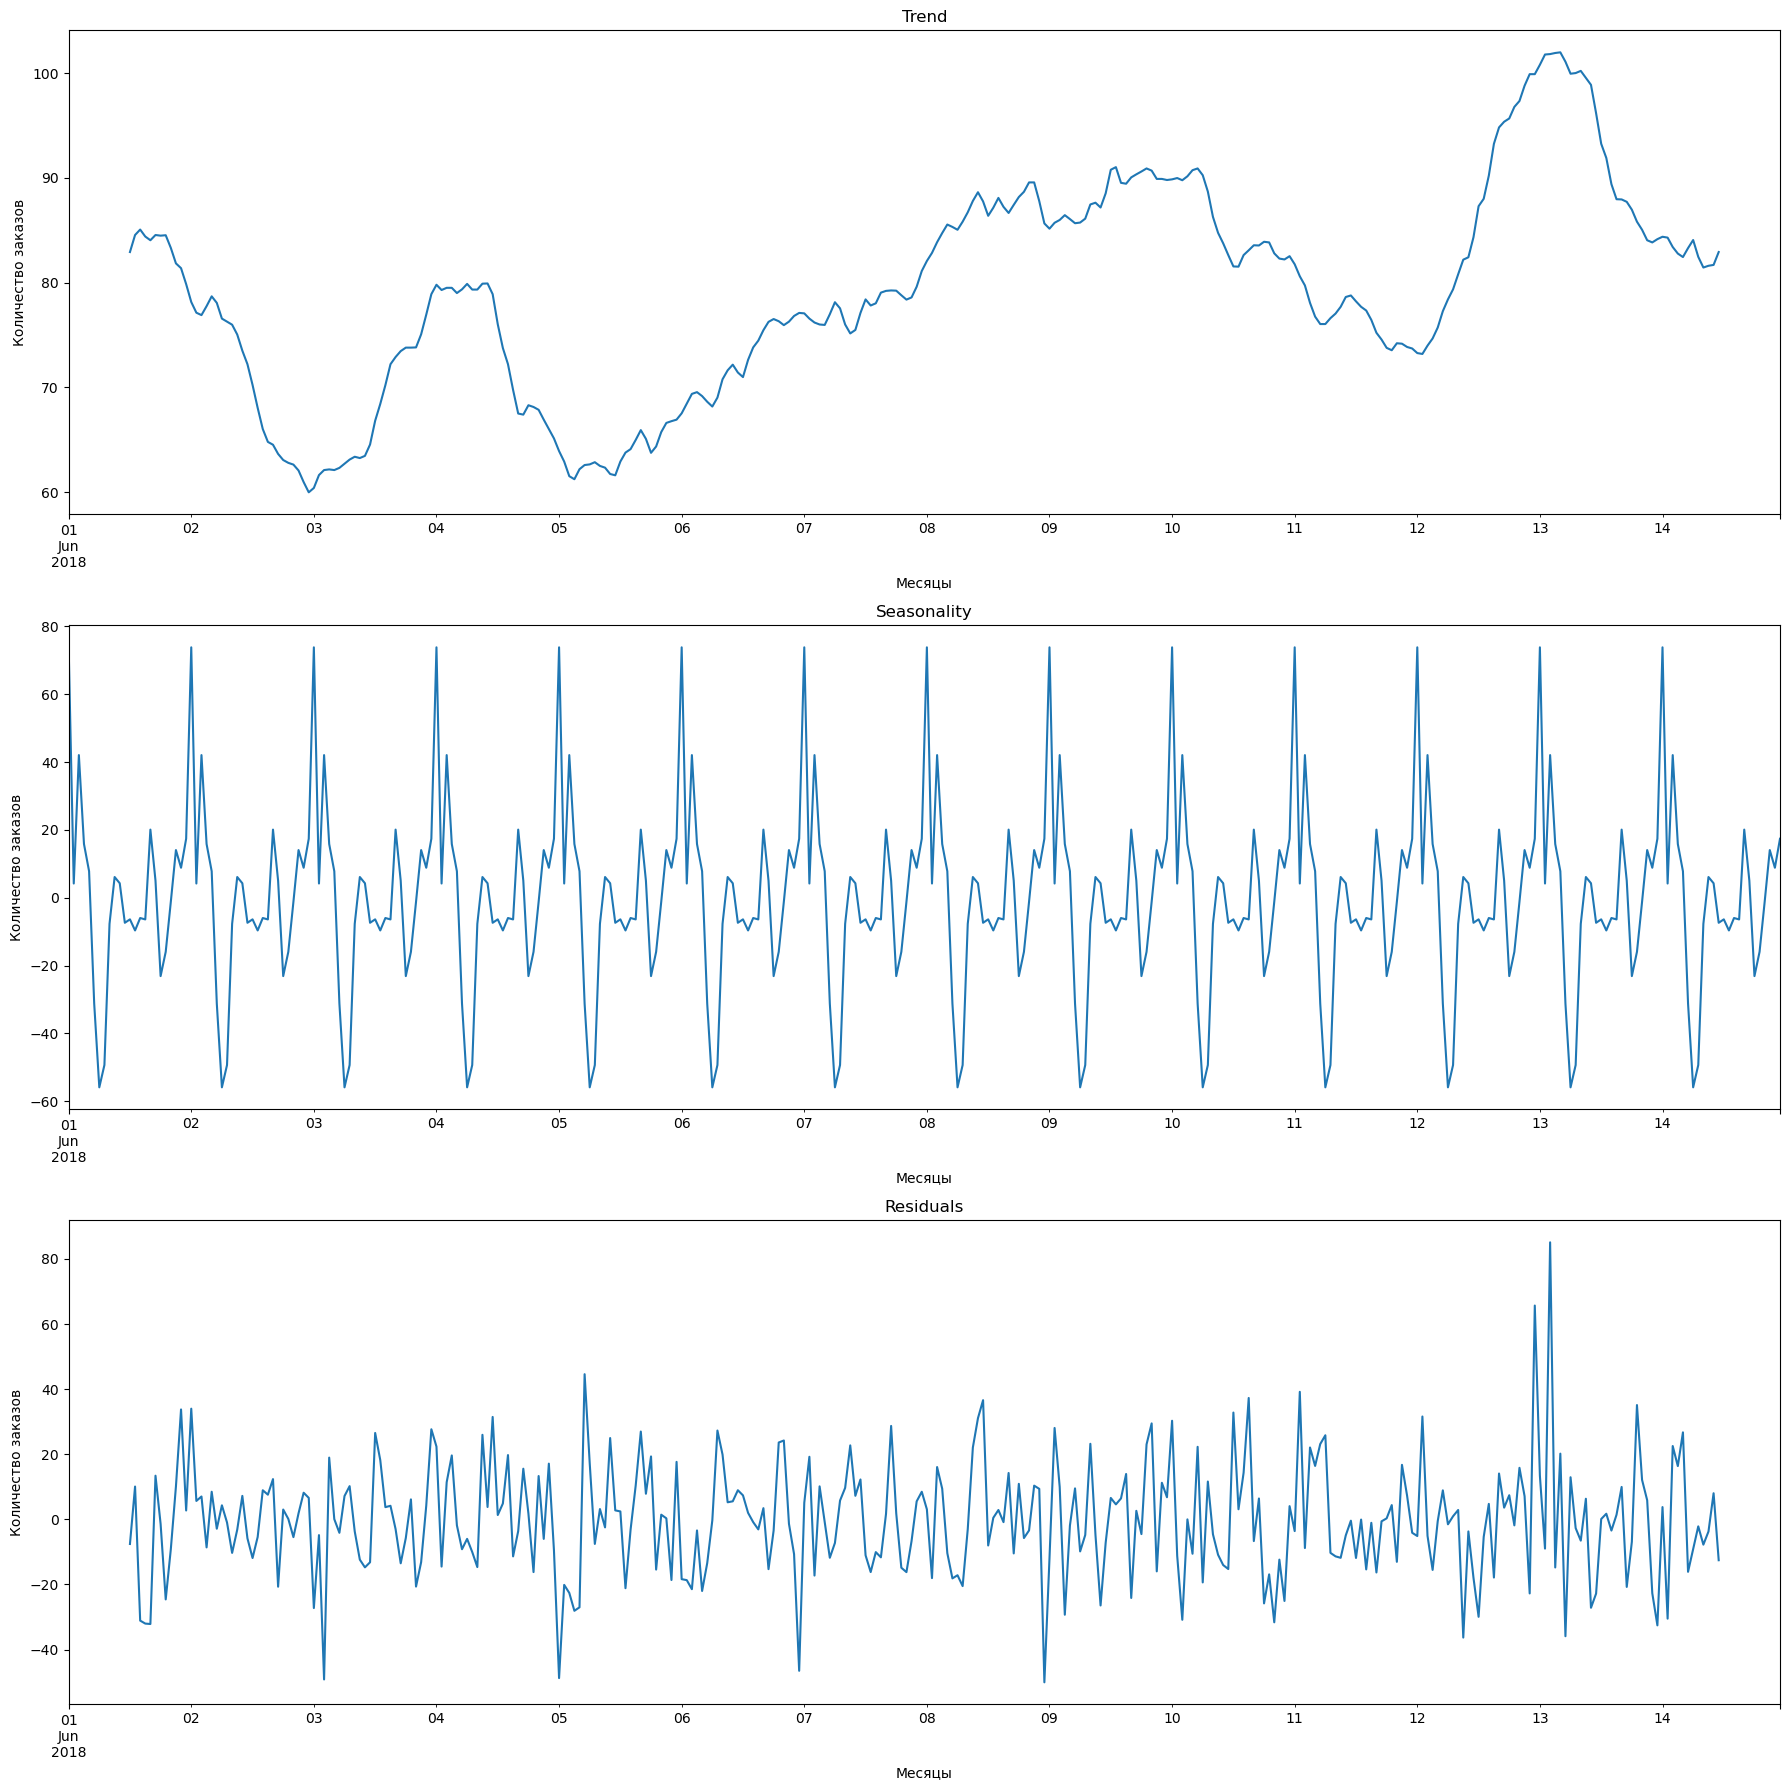

In [16]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-14'])

plt.figure(figsize=(18, 18))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.tight_layout()


plt.show()

Теперь видно, что сезонность - 1 день.

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

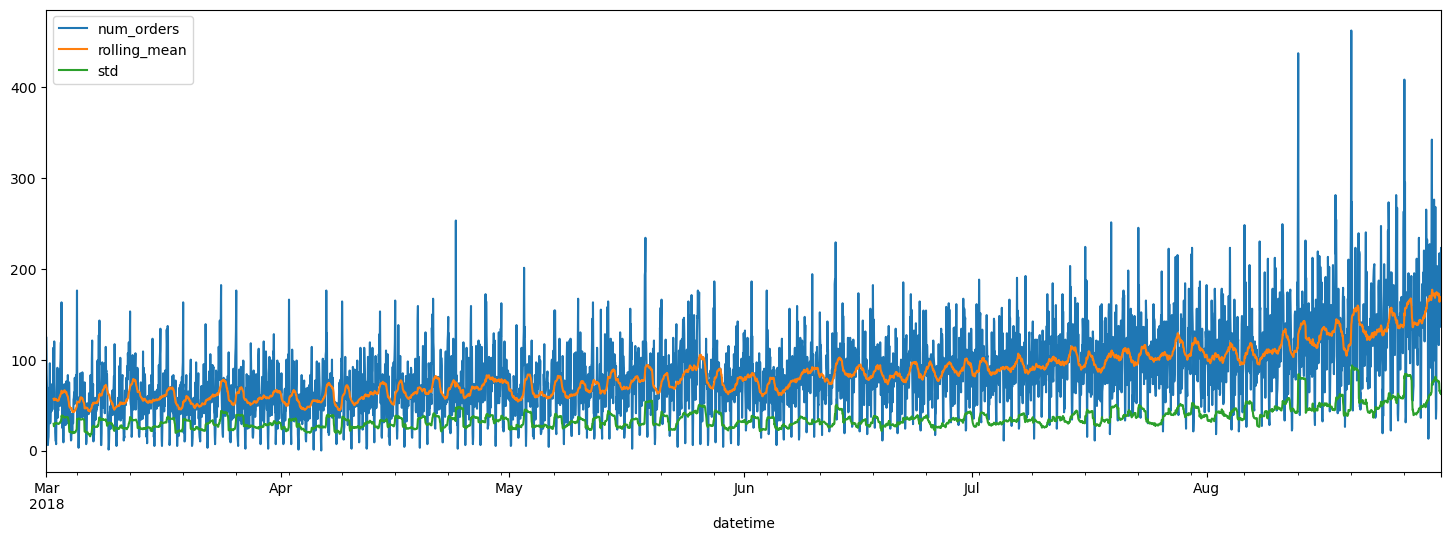

In [17]:
df2 = df.copy()
df2['rolling_mean'] = df2.rolling(24).mean()# 
df2['std'] = df2['num_orders'].rolling(24).std()
df2.plot(figsize=(18, 6))
plt.show()

Судя по графику можно сказать, что наши временные ряды не стационарные, так как видно изменение среднего и стандартного отклонения. 

### Вывод:

В результате анализа была выявлена сезонность периодом 1 день, также стало понятно, что временные ряды не стационарные, так как видно изменение среднего и стандартного отклонения. Чем обусловлен рост, предположить сложно, хотелось бы изучить данные за несколько лет.

## Обучение

Рассмотрю три модели: линейную регрессию, CatBoostRegressor и 
С помощью функции "make_features" создам дополнительные признаки: месяц, день недели, час, "отстающие значения", скользящее среднее:

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 24, 2)

In [20]:
df.isna().sum()#посмотрю пропуски

num_orders       0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
rolling_mean     2
dtype: int64

In [21]:
df = df.dropna()#удалю пропуски
df.isna().sum()#проперка

num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [22]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,85.5
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,74.0
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,105.0
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,97.5
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,69.5


In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [24]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(3952, 27)

(3952,)

(440, 27)

(440,)

Подберу гиперпараметры с помощью функцию TimeSeriesSplit(), так как мы используем временные ряды

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

Линейная регрессия

In [28]:
%%time
lr_params = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
print('Лучшие гиперпараметры: ', lr_best_params)

mts_lr = lr_grid.cv_results_['mean_test_score']
    
gscv_rsme_lr = (max(mts_lr) * -1) ** .5
display(gscv_rsme_lr)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False}


27.340524228677126

CPU times: total: 828 ms
Wall time: 426 ms


LGBMRegressor

In [29]:
%%time
lgb_params = {
        'n_estimators' : range(10, 50, 10),
        'max_depth' : range(3, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }

lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
print('Лучшие гиперпараметры: ', lgb_best_params)

mts_lgb = lgb_grid.cv_results_['mean_test_score']
    
gscv_rsme_lgb = (max(mts_lgb) * -1) ** .5
display(gscv_rsme_lgb)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_

25.32217920576288

CPU times: total: 32.7 s
Wall time: 11.6 s


RandomForestRegressor

In [30]:
%%time
rf_params = {
        'n_estimators' : range(10, 50, 10),
        'max_depth' : range(3, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }


rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_

print('Лучшие гиперпараметры: ', rf_best_params)

mts_rf = rf_grid.cv_results_['mean_test_score']
    
gscv_rsme_rf = (max(mts_rf) * -1) ** .5
display(gscv_rsme_rf)

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 40, 'random_state': 12345, 'verbose': 0}


25.67146185213371

CPU times: total: 2min 12s
Wall time: 2min 14s


## Тестирование

In [39]:
lr_m = LinearRegression(**lr_best_params)
lr_m.fit(features_train, target_train)
    
lr_test_pred = lr_m.predict(features_test)
lr_test_rmse = mean_squared_error(target_test, lr_test_pred)**0.5
print("RMSE тестовой выборки: ", lr_test_rmse)

RMSE тестовой выборки:  45.23826198269211


In [40]:
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train)
    
rf_test_pred = rf_m.predict(features_test)
rf_test_rmse = mean_squared_error(target_test, rf_test_pred)**0.5
print("RMSE тестовой выборки: ", rf_test_rmse)

RMSE тестовой выборки:  43.71693717570256


In [41]:
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
    
lgb_test_pred = lgb_m.predict(features_test)
lgb_test_rmse = mean_squared_error(target_test, lgb_test_pred)**0.5

print("RMSE тестовой выборки: ", lgb_test_rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
RMSE тестовой выборки:  41.447793547033726


In [42]:
#для наглядности соберу данные в сводную таблицу
index = ['Линейная регрессия',
         'RandomForestRegressor',
         'LGBMRegressor',
        ]

data = {'RMSE тестовой выборки':[lr_test_rmse,
                                 rf_test_rmse,
                                 lgb_test_rmse],
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,RMSE тестовой выборки
Линейная регрессия,45.238262
RandomForestRegressor,43.716937
LGBMRegressor,41.447794


## Вывод:

В результате работы над проектом были рассмотрены исходные данные (с 1 марта 2018 по 31 август 2018 г) и выполнена их предобработка. 
В результате анализа была выявлена сезонность периодом 1 день, также стало понятно, что временные ряды не стационарные, так как видно изменение среднего и стандартного отклонения. 
Рассмотрены 3 модели: линейная регрессия, RandomForestRegressor	и LGBMRegressor, путем проверки обученных моделей на тестовых выборках, модель LGBMRegressor показала лучшее значение RMSE = 41,5.
